In [4]:
from google.colab import files
uploaded = files.upload()

Saving data_f.mat to data_f.mat


In [8]:
pip install --upgrade tensorflow

     |████████████████████████████████| 462 kB 15.8 MB/s 
     |████████████████████████████████| 1.4 MB 38.3 MB/s 
  Attempting uninstall: keras
    Found existing installation: Keras 2.3.0
    Uninstalling Keras-2.3.0:
      Successfully uninstalled Keras-2.3.0


In [9]:
pip install --upgrade keras

In [5]:
tf.compat.v1.truncated_normal_initializer(
    mean=0.0, stddev=1.0, seed=None, dtype=tf.dtypes.float32
)


In [3]:
pip install Keras==2.3.0

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



  0%|          | 0/6 [00:00<?, ?it/s]

STRidge begins


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:411: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Adam begins



 17%|█▋        | 1/6 [00:35<02:57, 35.54s/it]

STRidge begins
Adam begins



 33%|███▎      | 2/6 [01:06<02:10, 32.59s/it]

STRidge begins
Adam begins



 50%|█████     | 3/6 [01:37<01:35, 31.88s/it]

STRidge begins
Adam begins



 67%|██████▋   | 4/6 [02:07<01:02, 31.44s/it]

STRidge begins
Adam begins



 83%|████████▎ | 5/6 [02:38<00:31, 31.22s/it]

STRidge begins
Adam begins



100%|██████████| 6/6 [03:09<00:00, 31.61s/it]


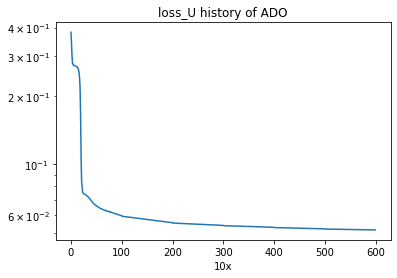

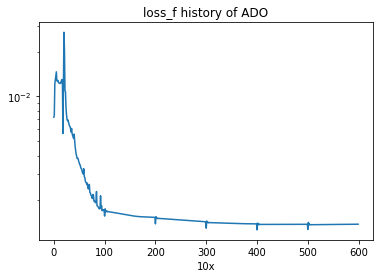

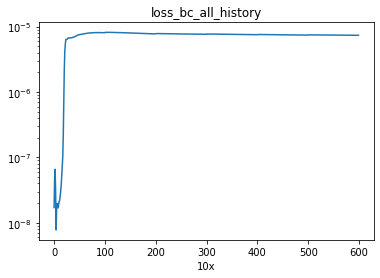

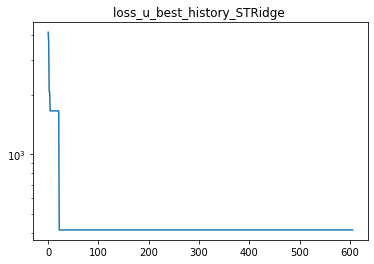

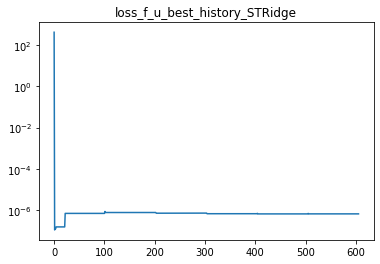

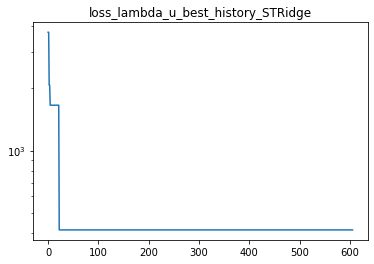

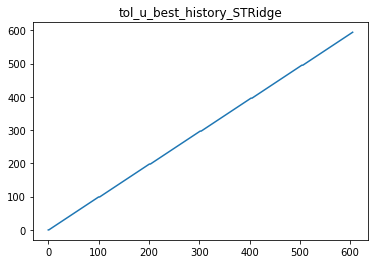

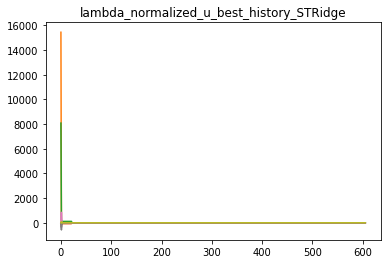

In [23]:

# =============================================================================
# Physics-informed learning of governing equations from scarce data
# Zhao Chen, Yang Liu, and Hao Sun
# 2021. Northeastern University

# please run ScratchAssay_Pre, ScratchAssay_ADO and ScratchAssay_Pt scripts in order.
# =============================================================================

#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
from pyDOE import lhs
from tqdm import tqdm
import os
tf.compat.v1.disable_eager_execution()
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # limite all operations on this GPU

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

with tf.device('/device:GPU:0'): # '/device:GPU:0' is GPU1 in task manager. Likewise, '/device:GPU:1' is GPU0.
        
    # ADO loss history
    loss_u_history = np.array([0])
    loss_f_u_history = np.array([0])
    loss_bc_all_history = np.array([0])
        
    # STRidge loss history   
    loss_u_best_history_STRidge = np.array([0])
    loss_f_u_best_history_STRidge = np.array([0])
    loss_lambda_u_best_history_STRidge = np.array([0])
    tol_u_best_history_STRidge = np.array([0])
    lambda_normalized_u_best_history_STRidge = np.zeros((9,1))
  
    lambda_u_history_STRidge = np.zeros((9, 1))
    ridge_u_append_counter_STRidge = np.array([0])

    np.random.seed(1234)
    def reset_random_seeds():
        os.environ['PYTHONHASHSEED']=str(2)
        tf.random.set_seed(1234)
        np.random.seed(1234)
        random.seed(1234)
    #tf.set_random_seed(1234)
    
    class PhysicsInformedNN:
# =============================================================================
#     Inspired by Raissi, Maziar, Paris Perdikaris, and George E. Karniadakis.
#     "Physics-informed neural networks: A deep learning framework for solving forward and inverse problems
#     involving nonlinear partial differential equations." Journal of Computational Physics 378 (2019): 686-707.
# =============================================================================

        # Initialize the class
        def __init__(self, X, U, X_f, X_l, X_r, layers, lb, ub, scale_factor):
            
            self.scale_factor = scale_factor
            
            self.lb = lb
            self.ub = ub
            
            # Initialize NNs
            self.weights, self.biases = self.initialize_NN(layers)

            #config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)
            config=tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=True)
            config.gpu_options.allow_growth = True
            self.sess = tf.Session(config = config)
            
            # Initialize parameters            
            self.lambda_u_tf = tf.placeholder(tf.float64, shape=[9, 1])

            # create these to make sure I can restore pretrained parameters
            self.lambda_u_core = tf.Variable(tf.random_uniform([8, 1], minval = -1, maxval = 1, dtype=tf.float64))
            self.diff_coeff_u_core = tf.Variable(tf.random_uniform([], minval = -1, maxval = 1, dtype=tf.float64))
            
            self.lambda_u = 50*tf.tanh(self.lambda_u_core)
            self.diff_coeff_u = 1000*tf.tanh(self.diff_coeff_u_core)

            # Specify the list of trainable variables 
            self.var_list_1 = self.weights + self.biases
            self.var_list_Pretrain = self.var_list_1 + [self.lambda_u_core] + [self.diff_coeff_u_core]
            
            ######### Training data ################            
            self.X_tf = tf.placeholder(tf.float64)
            self.U_tf = tf.placeholder(tf.float64)

            self.x_f_tf = tf.placeholder(tf.float64, shape=[None, 1])
            self.t_f_tf = tf.placeholder(tf.float64, shape=[None, 1])

            self.U_pred = self.net_U(self.X_tf)

            self.f_u_pred, self.Phi, self.u_t = self.net_f(self.x_f_tf, self.t_f_tf)
            self.loss_u = tf.reduce_mean(tf.square(self.U_tf - self.U_pred))

            self.loss_u_coeff = tf.placeholder(tf.float64)
            
            self.loss_U = self.loss_u_coeff*self.loss_u
            
            self.loss_f_u = 2e3*tf.reduce_mean(tf.square(self.f_u_pred))
            
            self.loss_f = self.loss_f_u
            
            self.loss_lambda_u = tf.norm(self.lambda_u, ord = 1) 
            
            self.x_l_tf = tf.placeholder(tf.float64)
            self.x_r_tf = tf.placeholder(tf.float64)        
            self.t_l_tf = tf.placeholder(tf.float64)
            self.t_r_tf = tf.placeholder(tf.float64)

            self.U_l = self.net_U(tf.concat((self.x_l_tf, self.t_l_tf), 1))
            self.U_r = self.net_U(tf.concat((self.x_r_tf, self.t_r_tf), 1))

            self.U_l_x = tf.gradients(self.U_l, self.x_l_tf)[0]
            self.U_r_x = tf.gradients(self.U_r, self.x_r_tf)[0]
            self.loss_bc = tf.reduce_mean(tf.square(self.U_l_x)) + tf.reduce_mean(tf.square(self.U_r_x))
            self.loss_bc_coeff = tf.placeholder(tf.float64)

            self.loss_ADO = tf.log(self.loss_U + self.loss_f + self.loss_bc_coeff*self.loss_bc)
            
# =============================================================================
# Optimizers
# =============================================================================
            # ADO opt
            self.global_step = tf.Variable(0, trainable=False)
            starter_learning_rate = 1e-3
            self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step, 1000, 0.5,
                                                         staircase=True)

            # The default settings: learning rate = 1e-3, beta1 = 0.9, beta2 = 0.999， epsilon = 1e-8
            self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate = self.learning_rate) 
            self.train_op_Adam = self.optimizer_Adam.minimize(self.loss_ADO, var_list = self.var_list_1, 
                                                              global_step = self.global_step)
            
            self.tf_dict = {self.X_tf: X,  self.U_tf: U, 
                            self.x_f_tf: X_f[:, 0:1], self.t_f_tf: X_f[:, 1:2],
                            self.x_l_tf: X_l[:, 0:1], self.t_l_tf: X_l[:, 1:2],
                            self.x_r_tf: X_r[:, 0:1], self.t_r_tf: X_r[:, 1:2]}    
            init = tf.global_variables_initializer()
            self.sess.run(init)
                
        def initialize_NN(self, layers):        
            weights = []
            biases = []
            num_layers = len(layers) 
            for l in range(0,num_layers-1):
                W = self.xavier_init(size=[layers[l], layers[l+1]])
                b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float64), dtype=tf.float64, name = 'b')
                weights.append(W)
                biases.append(b)        
                
            return weights, biases
            
        def xavier_init(self, size):
            in_dim = size[0]
            out_dim = size[1]        
            xavier_stddev = np.sqrt(2/(in_dim + out_dim))
            initial = tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=tf.float64, seed=None, name=None)
            return tf.Variable(initial, dtype=tf.float64, name = 'W')
           # return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=tf.float64),
                    #            dtype=tf.float64, name = 'W')
            
      #      initial = tf.random.truncated_normal(
  #  shape, mean=0.0, stddev=1.0, dtype=tf.dtypes.float32, seed=None, name=None)
            
            #initial = tf.truncated_normal(shape, stddev=0.1)
 
        def neural_net(self, X, weights, biases):
            num_layers = len(weights) + 1    
            H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
            W = weights[0]
            b = biases[0]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))

            for l in range(1, num_layers-2):
                W = weights[l]
                b = biases[l]
                H = tf.tanh(tf.add(tf.matmul(H, W), b))
                
            W = weights[-1]
            b = biases[-1]            
            # Y = tf.add(tf.matmul(H, W), b)
            Y = tf.log(tf.exp(tf.add(tf.matmul(H, W), b)) + 1) # softplus
            return Y
        
        def net_U(self, X):  
            U = self.neural_net(X, self.weights, self.biases)
            return U
                       
        def net_f(self, x, t):
            u = self.net_U(tf.concat((x, t), 1))

            u_t = tf.gradients(u, t)[0]
            u_x = tf.gradients(u, x)[0]
            u_xx = tf.gradients(u_x, x)[0]

            Phi = tf.concat((u_xx, tf.ones_like(x), u, u**2/self.scale_factor, u**3/self.scale_factor**2, u_x,
                             u_x*u/self.scale_factor, u_x*u**2/self.scale_factor**2, u_x*u**3/self.scale_factor**3), axis = 1)
            
            self.lib_descr = ['u_xx', '1', 'u', 'u**2', 'u**3', 'u_x', 'u_x*u', 'u_x*u**2', 'u_x*u**3']
            f_u = tf.matmul(Phi, self.lambda_u_tf) - u_t
                        
            return f_u, Phi, u_t

        def train(self): # nIter is the number of outer loop        
        
            self.tf_dict[self.loss_u_coeff] = 1
            self.tf_dict[self.loss_bc_coeff] = 1
            self.anneal_lam = [1, 1]
            self.anneal_alpha = 0.8
            
            sess =  tf.Session()
            saver = tf.train.Saver(self.var_list_Pretrain)                        
            #saver.restore(self.sess, './saved_variable_Pre') #fix here
            #sess =  tf.Session()
            #saver = tf.train.Saver(self.var_list_Pretrain)
            #saver.restore(self.sess,tf.train.lasest_checkpoint('saved_variable_Pre')

            # initialize STRidge tol, then inherit it previous ADO epochs
            self.MyTol_u = 0
            
            # pass pretrained lambda and diffu coeff to new lambda_tf
            lambda_u, diff_coeff_u = self.sess.run([self.lambda_u, self.diff_coeff_u])
            diff_coeff_u = np.reshape(diff_coeff_u, (1, 1))
            self.tf_dict[self.lambda_u_tf] = np.concatenate((diff_coeff_u, lambda_u), axis = 0)
            
            # ADO
            for self.it in tqdm(range(6)):    
                # Loop of STRidge estimation
                print('STRidge begins')
                self.callTrainSTRidge()

                # Loop of Adam optimization
                print('Adam begins')
                for it_Adam in tqdm(range(1000)):    # 2000
                    self.sess.run(self.train_op_Adam, self.tf_dict)                    
                    # Print
                    if it_Adam % 10 == 0:
                        loss_u, loss_f_u = self.sess.run([self.loss_u,self.loss_f_u], 
                                                                                self.tf_dict)
                        loss_bc = self.sess.run(self.loss_bc, self.tf_dict)


                        global loss_u_history
                        global loss_f_u_history
                        global loss_bc_all_history
                        
                        loss_u_history = np.append(loss_u_history, loss_u)
                        loss_f_u_history = np.append(loss_f_u_history, loss_f_u)
                        loss_bc_all_history = np.append(loss_bc_all_history, loss_bc)
            
            saver_ADO = tf.train.Saver(self.var_list_1)                        
            saved_path = saver_ADO.save(self.sess, './saved_variable_ADO')
                                
        def callTrainSTRidge(self):
            lam = 1e-10
            d_tol = 1
            maxit = 100
            STR_iters = 10
            l0_penalty = None
            normalize = 2
            split = 1
            Phi, u_t = self.sess.run([self.Phi, self.u_t], self.tf_dict) 
            
            lambda_u = self.TrainSTRidge(Phi, u_t, lam, d_tol, maxit, STR_iters, l0_penalty, normalize, split)
            self.tf_dict[self.lambda_u_tf] = lambda_u
                        
        def TrainSTRidge(self, R0, Ut, lam, d_tol, maxit, STR_iters = 10, l0_penalty = None, normalize = 2, split = 0.8):               
# =============================================================================
#        Inspired by Rudy, Samuel H., et al. "Data-driven discovery of partial differential equations."
#        Science Advances 3.4 (2017): e1602614.
# =============================================================================    

            # normalize ut
            Mreg_Ut = 1/(np.linalg.norm(Ut, normalize))
            # Ut2 = Ut*Mreg_Ut
            
            #  normalize library
            n,d = R0.shape
            if normalize != 0:
                Mreg = np.zeros((d,1))
                for i in range(0,d):
                    Mreg[i] = 1.0/(np.linalg.norm(R0[:,i],normalize))/Mreg_Ut
            # Set up the initial tolerance and l0 penalty
            d_tol = float(d_tol)
            tol = self.MyTol_u
                
            w_best = self.tf_dict[self.lambda_u_tf]
            
            err_f = np.mean((Ut - R0.dot(w_best))**2)
            
            if l0_penalty == None and self.it == 0: 
                self.l0_penalty_0 = err_f
                l0_penalty = self.l0_penalty_0
                    
            elif l0_penalty == None:
                l0_penalty = self.l0_penalty_0
                
            err_lambda = l0_penalty*np.count_nonzero(w_best)
            err_best = err_f + err_lambda
            
            tol_best = tol
                        
            global loss_u_best_history_STRidge 
            global loss_f_u_best_history_STRidge 
            global loss_lambda_u_best_history_STRidge 
            global tol_u_best_history_STRidge 
            global lambda_normalized_u_best_history_STRidge                 
            loss_u_best_history_STRidge = np.append(loss_u_best_history_STRidge, err_best)
            loss_f_u_best_history_STRidge = np.append(loss_f_u_best_history_STRidge, err_f)
            loss_lambda_u_best_history_STRidge = np.append(loss_lambda_u_best_history_STRidge, err_lambda)
            tol_u_best_history_STRidge = np.append(tol_u_best_history_STRidge, tol_best)
            lambda_normalized_u_best_history_STRidge = np.append(lambda_normalized_u_best_history_STRidge,
                                                            np.reshape(w_best/Mreg, (-1, 1)), axis = 1)
        
            # Now increase tolerance until test performance decreases
            for iter in range(maxit):
                # Get a set of coefficients and error
                w = self.STRidge(R0, Ut, lam, STR_iters, tol, normalize)
                err_f = np.mean((Ut - R0.dot(w))**2)
                err_lambda = l0_penalty*np.count_nonzero(w)
                err = err_f + err_lambda
        
                # Has the accuracy improved?
                if err <= err_best:
                    err_best = err
                    w_best = w
                    tol_best = tol
                    tol = tol + d_tol
                    
                    loss_u_best_history_STRidge = np.append(loss_u_best_history_STRidge , err_best)
                    loss_f_u_best_history_STRidge = np.append(loss_f_u_best_history_STRidge , err_f)
                    loss_lambda_u_best_history_STRidge = np.append(loss_lambda_u_best_history_STRidge,
                                                                        err_lambda)
                    tol_u_best_history_STRidge = np.append(tol_u_best_history_STRidge, tol_best)
                    lambda_normalized_u_best_history_STRidge = np.append(lambda_normalized_u_best_history_STRidge,
                                                                        np.reshape(w_best/Mreg, (-1, 1)), axis = 1)
                else:
                    tol = max([0,tol - 2*d_tol])
                    d_tol  = 2*d_tol / (maxit - iter)
                    tol = tol + d_tol
                                     
            self.MyTol_u = tol_best
            
            return np.real(w_best)     
        
        def STRidge(self, X0, y, lam, maxit, tol, normalize, print_results = False):
            

            # First normalize data 
            n,d = X0.shape
            X = np.zeros((n,d), dtype=np.float64)
            Mreg = np.zeros((d,1))
            for i in range(0,d):
                Mreg[i] = 1.0/(np.linalg.norm(X0[:,i], normalize))
                X[:,i] = Mreg[i]*X0[:,i]               

            # normalize ut
            Mreg_y = 1/(np.linalg.norm(y, normalize))
            y = y*Mreg_y
            Mreg = Mreg/Mreg_y
            
            w = self.tf_dict[self.lambda_u_tf]/Mreg

            num_relevant = d
            
            # norm threshold
            biginds = np.where(abs(w[1:]) > tol)[0] + 1 # keep diffu term unpruned
            biginds = np.insert(biginds, obj = 0, values = 0) # keep diffu u term unpruned

            global ridge_u_append_counter_STRidge
            ridge_u_append_counter = 0
                
            global lambda_u_history_STRidge
            lambda_u_history_STRidge = np.append(lambda_u_history_STRidge, np.multiply(Mreg,w), axis = 1)
            ridge_u_append_counter += 1

            # Threshold and continue
            for j in range(maxit):
        
                # Figure out which items to cut out
                
                # norm threshold
                smallinds = np.where(abs(w[1:]) < tol)[0] + 1 # dont threhold diffu term
                
                new_biginds = [i for i in range(d) if i not in smallinds]
                    
                # If nothing changes then stop
                if num_relevant == len(new_biginds): break
                else: num_relevant = len(new_biginds)
                    
                # Also make sure we didn't just lose all the coefficients
                if len(new_biginds) == 0:
                    if j == 0: 
                        lambda_u_history_STRidge = np.append(lambda_u_history_STRidge, w*Mreg, axis = 1)
                        ridge_u_append_counter += 1
                        ridge_u_append_counter_STRidge = np.append(ridge_u_append_counter_STRidge, ridge_u_append_counter)
                        return w*Mreg
                    else: break
                
                biginds = new_biginds
                
                # Otherwise get a new guess
                w[smallinds] = 0
                
                if lam != 0: 
                    w[biginds] = np.linalg.lstsq(X[:, biginds].T.dot(X[:, biginds]) + \
                                                          lam*np.eye(len(biginds)), X[:, biginds].T.dot(y))[0]
                    lambda_u_history_STRidge = np.append(lambda_u_history_STRidge, np.multiply(Mreg,w), axis = 1)
                    ridge_u_append_counter += 1
                else: 
                    w[biginds] = np.linalg.lstsq(X[:, biginds],y)[0]
                    lambda_u_history_STRidge = np.append(lambda_u_history_STRidge, np.multiply(Mreg,w), axis = 1)
                    ridge_u_append_counter += 1
            # Now that we have the sparsity pattern, use standard least squares to get w
            if biginds != []: w[biginds] = np.linalg.lstsq(X[:, biginds],y)[0]
            
            lambda_u_history_STRidge = np.append(lambda_u_history_STRidge, w*Mreg, axis = 1)
            ridge_u_append_counter += 1
            ridge_u_append_counter_STRidge = np.append(ridge_u_append_counter_STRidge, ridge_u_append_counter)

            return w*Mreg
        
        def predict(self, X_star):            
            tf_dict = {self.X_tf: X_star}            
            U = self.sess.run(self.U_pred, tf_dict)
            return U
        
    if __name__ == "__main__":              
        start_time = time.time()       
        layers = [2] + 3*[30] + [1]
# =============================================================================
# load data
# =============================================================================
        data = scipy.io.loadmat('data_f.mat')
        
        # use the average at all time steps
        Exact = np.real(data['C'])
        t = np.real(data['t'].flatten()[:,None])
        x = np.real(data['x'].flatten()[:,None])

        scale_factor = 1e3
        Exact = Exact*scale_factor # upscale data for better training

        xx, tt = np.meshgrid(x, t)
        
        X_star = np.hstack((xx.flatten()[:,None], tt.flatten()[:,None]))
        U_star = Exact.flatten()[:,None]            
        # flux = 0 bc
        X_l = np.hstack((xx[:, 0].flatten()[:,None],
                              tt[:, 0].flatten()[:,None]))
        X_r = np.hstack((xx[:, -1].flatten()[:,None], 
                              tt[:, -1].flatten()[:,None]))
        # Doman bounds
        lb = X_star.min(0)
        ub = X_star.max(0)    
            
        # Measurement data
        X_U_meas = X_star
        U_meas = U_star
        
        # Collocation points
        N_f = 10000    
        X_f_train = lb + (ub-lb)*lhs(X_U_meas.shape[1], N_f)
        
        X_f_train = np.vstack((X_f_train, X_U_meas))
                        
# =============================================================================
#         train model
# =============================================================================
        model = PhysicsInformedNN(X_U_meas, U_meas, X_f_train, X_l, X_r, layers, lb, ub, scale_factor)
        model.train() 
        
# =============================================================================
#         result
# =============================================================================
        f = open("stdout_ADO.txt", "a+")  
        elapsed = time.time() - start_time                
        f.write('Training time: %.4f \n' % (elapsed))
        
        U_Full_Pred = model.predict(X_star)  
        error_U = np.linalg.norm(np.reshape(U_star - U_Full_Pred, (-1,1)),2)/np.linalg.norm(np.reshape(U_star, (-1,1)),2)   
        f.write('Full Field Error u: %e \n' % (error_U))    
        
        lambda_u_pred = model.tf_dict[model.lambda_u_tf]      

        disc_eq_temp = []
        for i_lib in range(len(model.lib_descr)):
            if lambda_u_pred[i_lib] != 0:
                disc_eq_temp.append(str(lambda_u_pred[i_lib,0]) + model.lib_descr[i_lib])

        disc_eq_u = '+'.join(disc_eq_temp)        
        f.write('The discovered equation(ADO): u_t = ' + disc_eq_u)
        
        f.close()
        
        scipy.io.savemat('DiscLam_ADO.mat', {'Lamu_Disc': lambda_u_pred})

        scipy.io.savemat('PredSol_ADO.mat', {'U_Full_Pred': U_Full_Pred/scale_factor, 'U_star': U_star/scale_factor})

        scipy.io.savemat('Histories_ADO.mat', {'lambda_u_history_STRidge': lambda_u_history_STRidge,
                                         'ridge_u_append_counter_STRidge': ridge_u_append_counter_STRidge})
                         
        ######################## Plots for ADO #################            
        fig = plt.figure()
        plt.plot(loss_u_history[1:])
        plt.yscale('log')       
        plt.xlabel('10x')
        plt.title('loss_U history of ADO')  
        plt.savefig('1_ADO.png')
        
        fig = plt.figure()
        plt.plot(loss_f_u_history[1:])
        plt.yscale('log')       
        plt.xlabel('10x')
        plt.title('loss_f history of ADO')     
        plt.savefig('2_ADO.png')
        
        fig = plt.figure()
        plt.plot(loss_bc_all_history[1:])
        plt.xlabel('10x')
        plt.yscale('log')       
        plt.title('loss_bc_all_history')  
        plt.savefig('3_ADO.png')        
                
        ########################## Plots for Ridge #######################
        
        fig = plt.figure()
        plt.plot(loss_u_best_history_STRidge[1:])
        plt.yscale('log')       
        plt.title('loss_u_best_history_STRidge ')
        plt.savefig('4_ADO.png')
        
        fig = plt.figure()
        plt.plot(loss_f_u_best_history_STRidge[1:])
        plt.yscale('log')       
        plt.title('loss_f_u_best_history_STRidge')  
        plt.savefig('5_ADO.png')
        
        fig = plt.figure()
        plt.plot(loss_lambda_u_best_history_STRidge[1:])
        plt.yscale('log')       
        plt.title('loss_lambda_u_best_history_STRidge')
        plt.savefig('6_ADO.png')
        
        fig = plt.figure()
        plt.plot(tol_u_best_history_STRidge[1:])
        plt.title('tol_u_best_history_STRidge')
        plt.savefig('7_ADO.png')
                
        fig = plt.figure()
        for i in range(lambda_normalized_u_best_history_STRidge.shape[0]):
            plt.plot(lambda_normalized_u_best_history_STRidge[i, 1:])
        plt.title('lambda_normalized_u_best_history_STRidge')
        plt.savefig('8_ADO.png')

In [2]:
pip install --upgrade pyDOE

  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=f0f76e05700af2c29a6289ab49fe4caecb49aba259c216a53c44a26774b9523f
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE
